In [42]:
# Arabic Text Clustering - Complete Working Version
# -*- coding: utf-8 -*-

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
import warnings
warnings.filterwarnings('ignore')

# Download Arabic stopwords if not already available
import nltk
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# ==============================================
# 1. Enhanced Arabic Text Preprocessing
# ==============================================

def is_arabic_char(char):
    """Check if character is within Arabic Unicode blocks"""
    code = ord(char)
    return (
        (0x0600 <= code <= 0x06FF) or  # Basic Arabic
        (0x0750 <= code <= 0x077F) or  # Arabic Supplement
        (0x08A0 <= code <= 0x08FF) or  # Arabic Extended-A
        (0xFB50 <= code <= 0xFDFF) or  # Arabic Presentation Forms-A
        (0xFE70 <= code <= 0xFEFF)     # Arabic Presentation Forms-B
    )

def preprocess_arabic_text(text):
    """Comprehensive Arabic text preprocessing"""
    if not isinstance(text, str):
        return ""
    
    # Normalization
    text = araby.normalize_hamza(text)
    text = araby.normalize_ligature(text)
    text = araby.normalize_alef(text)
    text = araby.strip_tashkeel(text)  # Remove diacritics
    text = araby.strip_tatweel(text)   # Remove elongation characters
    
    # Clean special characters and keep only Arabic letters and spaces
    cleaned_text = [char for char in text if is_arabic_char(char) or char.isspace()]
    text = ''.join(cleaned_text)
    
    # Convert to lowercase and tokenize
    text = text.lower()
    words = text.split()
    
    # Remove stopwords and empty strings
    arabic_stopwords = set(stopwords.words('arabic'))
    words = [word for word in words if word not in arabic_stopwords and len(word) > 1]
    
    # Light stemming
    stemmer = ISRIStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return " ".join(words)

In [44]:
# ==============================================
# 2. Data Loading and Preparation
# ==============================================

# Load sample data (replace with your actual data loading)
df = pd.read_csv("full_data_fusionne.csv")

# Combine title and content for better clustering
df['text'] = df['title'] 

# Apply preprocessing
print("Preprocessing text...")
df['processed_text'] = df['text'].apply(preprocess_arabic_text)

# Show sample of processed text
print("\nSample processed text:")
print(df['processed_text'].head())

Preprocessing text...

Sample processed text:
0    ءلعاب ءولمب لكم خلف بلغ ربع نهء جزءر نكر دعي ب...
1    حطة ءفريق ءلعاب ءولمب ارس خيم بلد عبر ثرء قرة راء
2         ندد غيل هنة ظهر نهض لءسراءيل ءسطنبول ونس ربط
3                  ءسراءيل غال صحف صور قنة جزر قطع غزة
4                خلل حية غيل هنة جرم بد ركب ءن دفع ثمن
Name: processed_text, dtype: object


In [45]:
# ==============================================
# 3. Feature Extraction with TF-IDF
# ==============================================

# Create TF-IDF features
print("\nCreating TF-IDF features...")
vectorizer = TfidfVectorizer(
    max_features=500,
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.85
)

X = vectorizer.fit_transform(df['processed_text'])
print(f"TF-IDF matrix shape: {X.shape}")

# Get feature names
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample feature names: {feature_names[:10]}")


Creating TF-IDF features...
TF-IDF matrix shape: (51487, 500)

Sample feature names: ['ءءخر' 'ءءلاف' 'ءبب' 'ءبرز' 'ءبض' 'ءثر' 'ءثيوب' 'ءجراء' 'ءجل' 'ءحد']


In [46]:
# ==============================================
# 4. Determine Optimal Number of Clusters
# ==============================================

def find_optimal_clusters(X, max_k=10):
    """Find optimal k using Elbow method and Silhouette analysis"""
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k+1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        
        if k > 1:  # Silhouette score requires at least 2 clusters
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Plot Elbow method
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    
    # Plot Silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(k_range[1:], silhouette_scores, 'go-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis For Optimal k')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k (where silhouette score peaks)
    optimal_k = k_range[1:][np.argmax(silhouette_scores)]
    print(f"Recommended number of clusters: {optimal_k}")
    return optimal_k

# Find optimal clusters (using 4 for our small sample)
optimal_k = 2  # For sample data, we'll use 2 clusters
print(f"Using {optimal_k} clusters for this example")

Using 2 clusters for this example



Performing K-means clustering with k=2...

🔹 Silhouette Score: 0.007
🔹 Inertia: 49893.31

Cluster distribution:
cluster
0    44707
1     6780
Name: count, dtype: int64


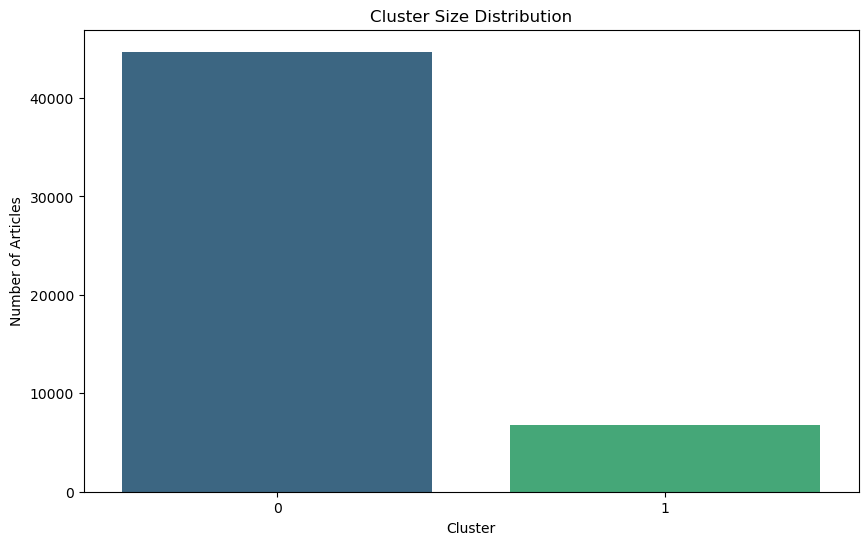

In [47]:
# ==============================================
# 5. Perform Clustering
# ==============================================

# Perform K-means clustering with optimal k
print(f"\nPerforming K-means clustering with k={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

# Evaluation metrics
silhouette_avg = silhouette_score(X, df['cluster'])
print(f"\n🔹 Silhouette Score: {silhouette_avg:.3f}")
print(f"🔹 Inertia: {kmeans.inertia_:.2f}")

# Show cluster distribution
cluster_dist = df['cluster'].value_counts().sort_index()
print("\nCluster distribution:")
print(cluster_dist)

# Visualize cluster sizes
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_dist.index, y=cluster_dist.values, palette='viridis')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Articles')
plt.show()


Reducing dimensions for visualization...


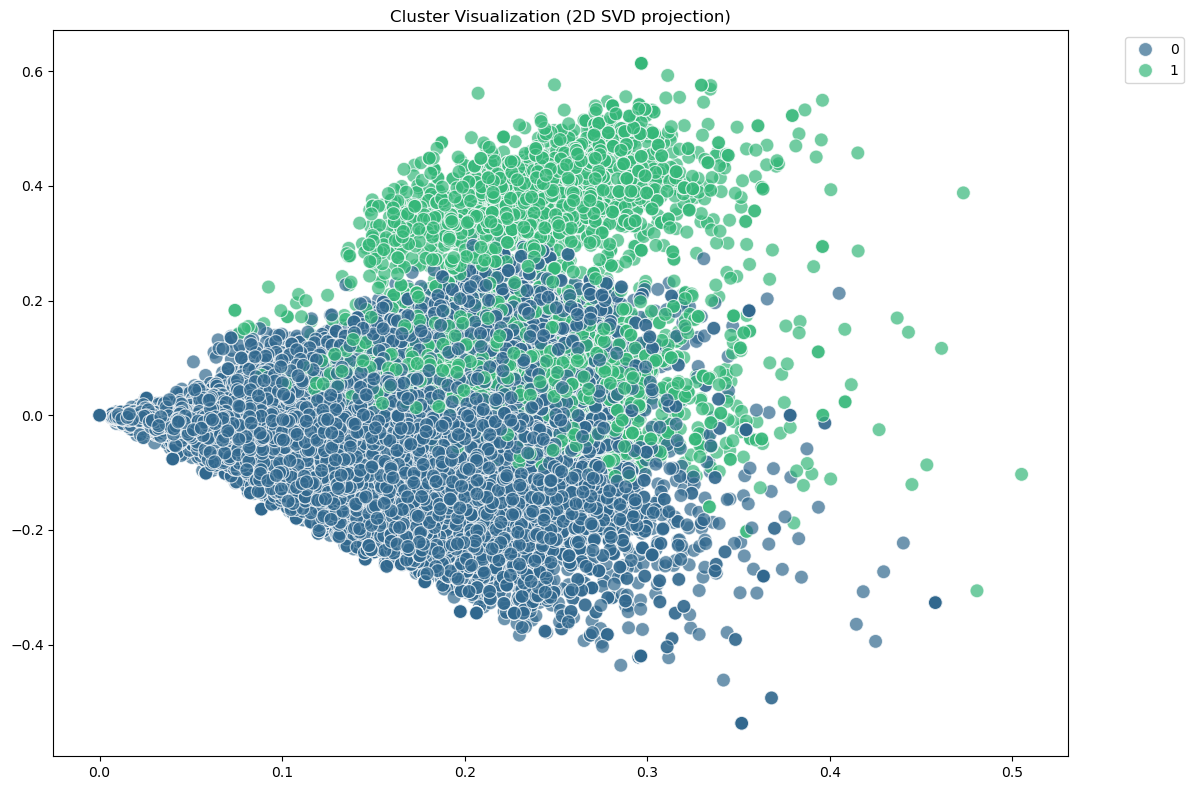


Top terms per cluster:

Cluster 0: ءمر علا رمب غزة ءسراءيلي رءس ءلا قتل سور جدد
Cluster 1: ءسراءيل الل حزب حزب الل علا لبن ءير هجم غزة قتل

In [48]:
# ==============================================
# 6. Cluster Visualization and Interpretation
# ==============================================

# Visualize clusters in 2D space
print("\nReducing dimensions for visualization...")
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['cluster'], 
                palette='viridis', alpha=0.7, s=100)
plt.title('Cluster Visualization (2D SVD projection)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Show top terms per cluster
print("\nTop terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(optimal_k):
    print(f"\nCluster {i}:", end='')
    for ind in order_centroids[i, :10]:
        print(f" {feature_names[ind]}", end='')

In [ ]:
# ==============================================
# 7. Examine Cluster Contents
# ==============================================

# Function to display sample articles from each cluster
def show_cluster_samples(df, cluster_num):
    cluster_df = df[df['cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} - {len(cluster_df)} articles")
    print("="*50)
    
    for idx, row in cluster_df.iterrows():
        print(f"\nTitle: {row['title']}")
        print(f"Content: {row['content'][:100]}...")
        print("-"*50)

# Show samples from each cluster
for cluster_num in sorted(df['cluster'].unique()):
    show_cluster_samples(df, cluster_num)


Cluster 0 - 44707 articles

Title: الألعاب الأولمبية: الملاكمة خليف تبلغ ربع النهائي والجزائر تستنكر الدعاية "الباطلة" ضدها
Content: تغلبت الملاكمة الجزائرية إيمان خليف على خصمتها أنجيلا كاريني الخميس في أولمبياد باريس إثر انسحاب الإ...
--------------------------------------------------

Title: محطة أفريقيا في الألعاب الأولمبية بباريس: "خيمة كل بلد تعبر عن ثراء القارة السمراء"
Content: موفد فرانس24 إلى سان دوني – تتواصل فعاليات معرض "َAfrica Station" (محطة أفريقيا) في ضاحية سان دوني ا...
--------------------------------------------------

Title: تنديدا باغتيال هنية... مظاهرات مناهضة لإسرائيل في إسطنبول وتونس والرباط
Content: تظاهر آلاف الأشخاص في تركيا والمغرب وتونس تنديدا باغتيال رئيس المكتب السياسي لحماس إسماعيل هنية بطهر...
--------------------------------------------------

Title: خليل الحية عن اغتيال هنية.. هذه جريمة لا بد لمرتكبها أن يدفع الثمن
Content: خليل الحية القيادي في حماس: الحركة وإيران لا تريدان حربا إقليمية لكن هناك جريمة يتعين معاقبة مرتكبها...
-----------------------

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Title: مختصون يتوقعون أن يتضرر العراق من الصراع الأميركي الإيراني
Content: يتوقع مراقبون أن يكون العراق المتضررَ الأولَ من الصراع الأميركي الإيراني. ويوضح الخبراء أنه بغض النظ...
--------------------------------------------------

Title: عرض دنماركي بـ"تريليون دولار" لشراء "أهم ولاية أميركية"
Content: يشارك مواطنون دنماركيون في حملة لجمع تريليون دولار من أجل شراء ولاية كاليفورنيا، الأكثر سكانا وازدها...
--------------------------------------------------

Title: ترامب يعلق على تقارير سحب القوات الأميركية من سوريا
Content: أعلن الرئيس الأميركي دونالد ترامب، الخميس، بأنه يعتزم اتخاذ قراره قريبا بشأن مصير القوات الأميركية ف...
--------------------------------------------------

Title: سياسة الضغط الأميركية قد تدفع إيران للسعي نحو اتفاق جديد
Content: بعد قرار الرئيس الأميركي دونالد ترامب التنفيذي باستئناف سياسة الضغط القصوى على إيران وإعلانِه رغبتَه...
--------------------------------------------------

Title: فيديو.. قتيل ومصابون بعد اصطدام طائرتين في مطار أميركي
Content: لقي شخص على الأق

In [ ]:
# ==============================================
# 8. Save Results
# ==============================================

# Save clustered results to CSV
output_file = "clustered_arabic_articles.csv"
df.to_csv(output_file, index=False)
print(f"\nResults saved to {output_file}")

# Save cluster labels and top terms
cluster_terms = {}
for i in range(optimal_k):
    cluster_terms[i] = [feature_names[ind] for ind in order_centroids[i, :10]]

terms_df = pd.DataFrame.from_dict(cluster_terms, orient='index')
terms_df.to_csv("cluster_top_terms.csv")
print("Top terms per cluster saved to cluster_top_terms.csv")

print("\nArabic text clustering completed successfully!")

In [ ]:
df